In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/PhD_Stuff/cheb_bessel_tests-main`


In [2]:
using BenchmarkTools
using LinearAlgebra
using DataInterpolations
using SpecialFunctions
using HCubature
using QuadGK
using Polynomials
using Plots
using FastChebInterp
using ProgressBars
using LaTeXStrings
using Bessels
using Tullio
using FFTW
using LoopVectorization
using NPZ
using Cubature
using FastTransforms
using Interpolations
using TwoFAST
using Dierckx
using DelimitedFiles

In [3]:
using Revise
using Will

In [4]:
#Import window functions
W = npzread("../N5K/input/kernels_fullwidth.npz")
WA = W["kernels_sh"]
WB = W["kernels_cl"]

nχ = 100
χ = LinRange(26, 7000, nχ) 
WA_interp = zeros(5,nχ)
WB_interp = zeros(10,nχ)

for i in 1:5
    interp = BSplineInterpolation(WA[i,:], W["chi_sh"], 3, :ArcLen, :Average, extrapolate=true)
    WA_interp[i,:] = interp.(χ)
end

for i in 1:10
    interp = BSplineInterpolation(WB[i,:], W["chi_cl"], 3, :ArcLen, :Average, extrapolate=true)
    WB_interp[i,:] = interp.(χ)
end

In [5]:
#import power spectrum
pk_dict = npzread("../N5K/input/pk.npz")

Dict{String, Array{Float64}} with 4 entries:
  "k"      => [0.0001, 0.000107189, 0.000114895, 0.000123155, 0.000132009, 0.00…
  "pk_lin" => [2051.02 2192.88 … 0.000739439 0.000615407; 1901.32 2032.83 … 0.0…
  "pk_nl"  => [2050.81 2192.64 … 0.0954076 0.0816359; 1901.13 2032.62 … 0.08061…
  "z"      => [0.0, 0.0714286, 0.142857, 0.214286, 0.285714, 0.357143, 0.428571…

In [6]:
interp = BSplineInterpolation(W["chi_cl"], W["z_cl"], 3, :ArcLen, :Average, extrapolate=true)
my_chi = interp.(pk_dict["z"]);

In [7]:
itp = interpolate((my_chi, log10.(pk_dict["k"])), log10.(pk_dict["pk_lin"]), Gridded(Linear()))
itp_with_extrapolation = extrapolate(itp, Line());

In [8]:
#Define our grid
kmax = 200/13 
kmin = 2.5/7000
k = LinRange(kmin, kmax, 40000)
nχ = 100
χ = LinRange(26, 7000, nχ)

log_pk_interp = [itp_with_extrapolation(i, j) for i in χ, j in log10.(k)];

In [9]:
function power_spectrum(k, χ1, χ2, interpolator)
    P1 = 10 .^interpolator(χ1, k)
    P2 = 10 .^interpolator(χ2, k)
    
    return @. sqrt(P1 * P2)
end

power_spectrum(k, χ1, χ2) = power_spectrum(k, χ1, χ2, itp_with_extrapolation);

In [10]:
#calculate coefficients of chebychev decomposition
n_cheb = 128
k_cheb = chebpoints(n_cheb, log10(kmin), log10(kmax));
coeff = zeros(nχ,nχ,n_cheb+1)
for i in 1:nχ
    for j in i:nχ
        c = chebinterp(power_spectrum(k_cheb,χ[i],χ[j]), log10(kmin), log10(kmax));
        coeff[i,j,:] = c.coefs
        coeff[j,i,:] = coeff[i,j,:]
    end
end

### CC

In [11]:
N = 4096
chi0 = 0.001
kmax = 1e4 #200/13 
kmin = 4e-5 #2.5/7000
q = 1.1
ell = [2] 
RR = [1.0]

# calculate M_ll at high ell, result gets saved to a file:
f21cache = F21EllCache(maximum(ell), RR, N; q=q, kmin=kmin, kmax=kmax, χ0=chi0)
write("out/F21EllCache", f21cache)

# calculate all M_ll, result gets saved to a file:
mlcache = MlCache(ell, "out/F21EllCache", "out/MlCache")
write("out/MlCache", mlcache)

# calculate wljj:
w00_CC = Array{Float64}(undef, N, length(RR))
w02 = Array{Float64}(undef, N, length(RR))
w22 = Array{Float64}(undef, N, length(RR))
function outfunc(wjj, ell, rr, RR)
    w00_CC[:,:] = wjj[1]
    #w02[:,:] = wjj[2]
    #w22[:,:] = wjj[3]
end
rr = calcwljj(x->power_spectrum(log10(x), 7000,7000), RR; ell=ell, kmin=kmin, kmax=kmax, N=N, r0=chi0, q=q, outfunc=outfunc, cachefile="out/MlCache/MlCache.bin");

  q=1.1, R=1.0:	  0.001153 seconds (8.20 k allocations: 576.281 KiB)

ℓ = 2
Δℓ = 4
ΔℓRg1 = -4
N = 4096
q = 1.1
kmin = 4.0e-5
kmax = 10000.0
χ0 = 0.001
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 4.0e-5
kmax = 10000.0
dlrec    = 4
dlrecRg1 = -4
Output size: 131136 bytes = 0.0001221299171447754 GiB
Output size: 131136 bytes = 0.0001221299171447754 GiB
Reading 'out/F21EllCache'...   0.005166 seconds (182 allocations: 132.203 KiB)
ellmax: 4
lmaxcache: 2
fell[:,1,1] = ComplexF64[849595.9453715278 - 2.0809099101356223e-10im, 0.0 + 0.0im]
ell 4, elapsed: 2.7894973754882812e-5
ell 3, elapsed: 0.290647029876709
ell 2, elapsed: 0.0042531490325927734
ell 1, elapsed: 0.0001621246337890625
ell 0, elapsed: 0.00015497207641601562
  0.313595 seconds (454.90 k allocations: 30.474 MiB, 4.56% gc time, 99.55% compilation time)
elapsed: 0.0002770423889160156
step:          0.087138 sec (107.509 k allocations: 7.59 MB, 0.0% gc time)
swapping:      3.0e-6 sec (0 allocations: 0 byte, 0.0% gc time)
calc_M

In [12]:
interp= Spline1D(rr, w00_CC[:,1])
w00_CC_interp = interp.(LinRange(26, 7000, 100) )*π/2;

In [16]:
nχ=100
n_cheb = 128

function load_T_CC(nχ, n_cheb, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_T = zeros(21, nχ, nχ, n_cheb+1)
    for i in 1:21
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "T_tilde_CC/T_tilde_l_$l_string.npy"
        full_T[i,:,:,:] = npzread(filename)
    end
    return full_T
end

T_CC = load_T_CC(nχ, n_cheb)


kmax = 200/13 
kmin = 2.5/7000
k_cheb = chebpoints(n_cheb, log10(kmin), log10(kmax));
coeff = zeros(nχ,nχ,n_cheb+1)
for i in 1:nχ
    for j in i:nχ
        c = chebinterp(power_spectrum.(k_cheb, χ[i],χ[j]), log10(kmin), log10(kmax));
        coeff[i,j,:] = c.coefs
        coeff[j,i,:] = coeff[i,j,:]
    end
end

w_CC = Will.w_ell_tullio(coeff, T_CC);

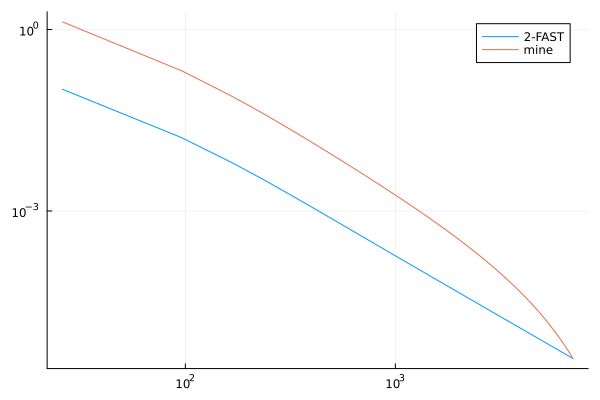

In [17]:
plot(LinRange(26, 7000, 100) ,w00_CC_interp, label="2-FAST", xscale=:log10, yscale=:log10)
#plot(rr ,w00, label="2-FAST", xscale=:log10, yscale=:log10)
plot!(LinRange(26, 7000, 100), diag(w_CC[1,:,:]), label="mine")

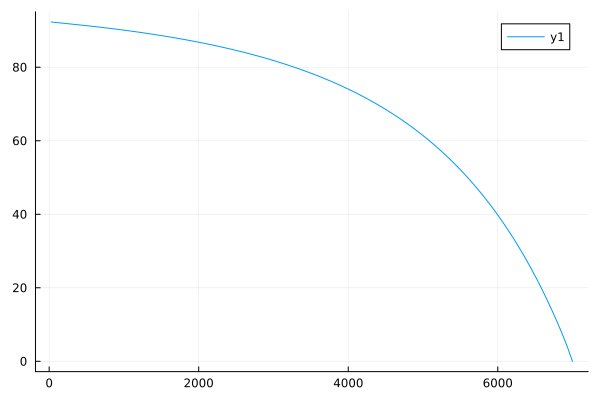

In [18]:
plot(LinRange(26, 7000, 100), 100*(1 .- (w00_CC_interp ./  diag(w_CC[1,:,:]))))

#### QuadOSc validation

In [19]:
using QuadOsc
using FunctionZeros

In [20]:
function quadosc_cc_valid(ℓ, χ)
    a, E = quadosc(x->pk(log10(x))*Bessels.sphericalbesselj(ℓ, χ*x)^2 * (x^2), kmin, Inf, n->besselj_zero(ℓ+0.5, n)/χ)
    b, Eb = quadosc(x->pk(log10(x))*Bessels.sphericalbesselj(ℓ, χ*x)^2 * (x^2), kmax, Inf, n->besselj_zero(ℓ+0.5, n)/χ)
    return a,b
end;

In [12]:
χ = LinRange(26, 7000, 10)
qosc_test_cc_a = zeros(10)
qosc_test_cc_b = zeros(10)
@time for (cidx, c) in enumerate(χ)
    println("Processing χ = $c");flush(stdout)
    qosc_test_cc_a[cidx], qosc_test_cc_b[cidx] = quadosc_cc_valid(2, c)
end

Processing χ = 26.0
Processing χ = 800.8888888888888
Processing χ = 1575.7777777777776
Processing χ = 2350.6666666666665
Processing χ = 3125.555555555555
Processing χ = 3900.444444444445
Processing χ = 4675.333333333333
Processing χ = 5450.222222222222
Processing χ = 6225.11111111111
Processing χ = 7000.0
6064.019923 seconds (1.55 G allocations: 33.055 TiB, 16.07% gc time, 0.02% compilation time)


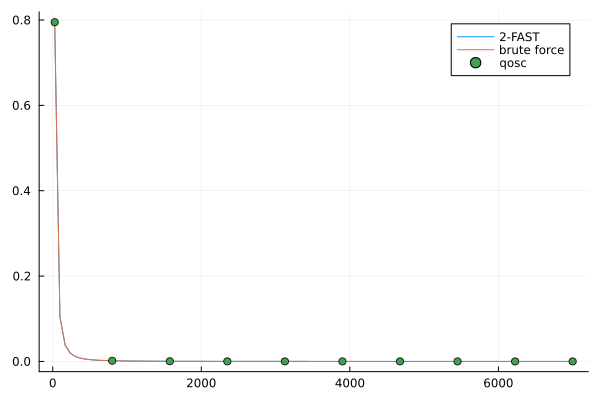

In [34]:
plot(LinRange(26, 7000, 100) ,w00_CC_interp, label="2-FAST")
plot!(LinRange(26, 7000, 100), diag(w_CC[1,:,:]), label="brute force")
scatter!(LinRange(26, 7000, 10), qosc_test_cc_a .-qosc_test_cc_b, label="qosc")

### LL

In [21]:
N = 4096
chi0 = 0.001
kmax = 1e4 #200/13 
kmin = 4e-5 #2.5/7000
q = -2.1
ell = [2] 
RR = [1.0]

# calculate M_ll at high ell, result gets saved to a file:
f21cache = F21EllCache(maximum(ell), RR, N; q=q, kmin=kmin, kmax=kmax, χ0=chi0)
write("out/F21EllCache", f21cache)

# calculate all M_ll, result gets saved to a file:
mlcache = MlCache(ell, "out/F21EllCache", "out/MlCache")
write("out/MlCache", mlcache)

# calculate wljj:
w00_LL = Array{Float64}(undef, N, length(RR))
function outfunc(wjj, ell, rr, RR)
    w00_LL[:,:] = wjj[1]
    #w02[:,:] = wjj[2]
    #w22[:,:] = wjj[3]
end
rr = calcwljj(x->power_spectrum(log10(x), 7000, 7000)/x^4, RR; ell=ell, kmin=kmin, kmax=kmax, N=N, r0=chi0, q=q, outfunc=outfunc, cachefile="out/MlCache/MlCache.bin");

  q=-2.1, R=1.0:	  0.005709 seconds (8.20 k allocations: 576.281 KiB)

ℓ = 2
Δℓ = 4
ΔℓRg1 = -4
N = 4096
q = -2.1
kmin = 4.0e-5
kmax = 10000.0
χ0 = 0.001
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 4.0e-5
kmax = 10000.0
dlrec    = 4
dlrecRg1 = -4
Output size: 131136 bytes = 0.0001221299171447754 GiB
Output size: 131136 bytes = 0.0001221299171447754 GiB
Reading 'out/F21EllCache'...   0.005576 seconds (180 allocations: 132.086 KiB)
ellmax: 4
lmaxcache: 2
fell[:,1,1] = ComplexF64[2.1789635155962566e-20 + 0.0im, 0.0 + 0.0im]
ell 4, elapsed: 2.47955322265625e-5
ell 3, elapsed: 0.00015091896057128906
ell 2, elapsed: 7.200241088867188e-5
ell 1, elapsed: 0.00017404556274414062
ell 0, elapsed: 0.00016999244689941406
  0.001110 seconds (338 allocations: 17.703 KiB)
elapsed: 0.0002830028533935547
step:          6.7e-5 sec (0 allocations: 0 byte, 0.0% gc time)
swapping:      1.0e-6 sec (0 allocations: 0 byte, 0.0% gc time)
calc_Mellell!: 3.9e-5 sec (0 allocations: 0 byte, 0.0% gc time)
  t0 : 

In [22]:
interp= Spline1D(rr, w00_LL[:,1])
w00_LL_interp = interp.(LinRange(26, 7000, 100) )*π/2;

In [25]:
function load_T_LL(nχ, n_cheb, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_T = zeros(21, nχ, nχ, n_cheb+1)
    for i in 1:21
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "T_tilde_LL/T_tilde_l_$l_string.npy"
        full_T[i,:,:,:] = npzread(filename)
    end
    return full_T
end

T_LL = load_T_LL(nχ, n_cheb)
w_LL = Will.w_ell_tullio(coeff, T_LL);

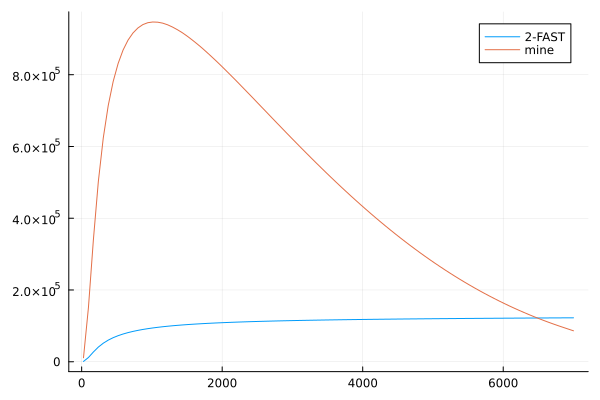

In [26]:
plot(LinRange(26, 7000, 100) ,w00_LL_interp, label="2-FAST")
plot!(LinRange(26, 7000, 100), diag(w_LL[1,:,:]), label="mine")

In [18]:
function quadosc_ll_valid(ℓ, χ)
    a, E = quadosc(x->power_spectrum(log10(x), χ, χ)*Bessels.sphericalbesselj(ℓ, χ*x)^2 / (x^2), kmin, Inf, n->besselj_zero(ℓ+0.5, n)/χ)
    b, Eb = quadosc(x->power_spectrum(log10(x), χ, χ)*Bessels.sphericalbesselj(ℓ, χ*x)^2 / (x^2), kmax, Inf, n->besselj_zero(ℓ+0.5, n)/χ)
    return a,b
end;

In [19]:
χ = LinRange(26, 7000, 10)
qosc_test_ll_a = zeros(10)
qosc_test_ll_b = zeros(10)
@time for (cidx, c) in enumerate(χ)
    println("Processing χ = $c");flush(stdout)
    qosc_test_ll_a[cidx], qosc_test_ll_b[cidx] = quadosc_ll_valid(2, c)
end

Processing χ = 26.0
Processing χ = 800.8888888888888
Processing χ = 1575.7777777777776
Processing χ = 2350.6666666666665
Processing χ = 3125.555555555555
Processing χ = 3900.444444444445
Processing χ = 4675.333333333333
Processing χ = 5450.222222222222
Processing χ = 6225.11111111111
Processing χ = 7000.0
898.818606 seconds (432.13 M allocations: 3.466 TiB, 20.75% gc time, 0.18% compilation time)


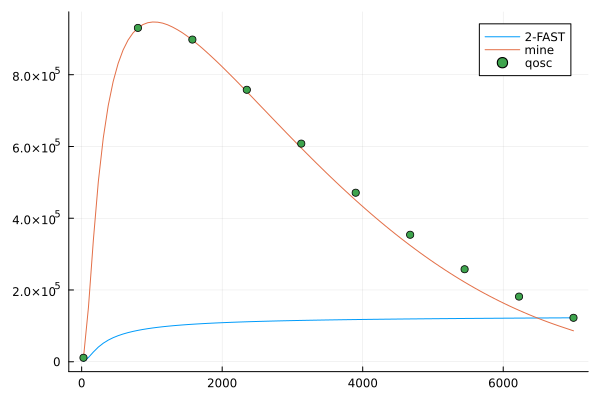

In [20]:
plot(LinRange(26, 7000, 100) ,w00_LL_interp, label="2-FAST")
plot!(LinRange(26, 7000, 100), diag(w_LL[1,:,:]), label="mine")
#scatter!(LinRange(26, 7000, 10), qosc_test_ll_a, label="qosc_a")
scatter!(LinRange(26, 7000, 10), qosc_test_ll_a .- qosc_test_ll_b, label="qosc")

In [85]:
function ll_p_ad(f, kmin, kmax, ℓ, χ)
    benchmark_f(x) = Bessels.sphericalbesselj.(ℓ, χ * x) * Bessels.sphericalbesselj.(ℓ, χ * x)*f(log10(x), 7000, 7000)/x^2
    int, err = Cubature.pquadrature(x->benchmark_f(x), kmin*(1+1e-8), kmax; reltol=sqrt(1e-14), abstol=0, maxevals=Int(1e6))
   return int
end

ll_p_ad (generic function with 1 method)

In [86]:
ll_padapt = zeros(10)
χ = LinRange(26, 7000, 10)

kmax = 200/13
kmin = 2.5/7000

@time for (cidx,c) in enumerate(χ)
    println("Processing χ = $c")
    ll_padapt[cidx] = ll_p_ad(power_spectrum, kmin, kmax, 2, c)
end

Processing χ = 26.0
Processing χ = 800.8888888888888
Processing χ = 1575.7777777777776
Processing χ = 2350.6666666666665
Processing χ = 3125.555555555555
Processing χ = 3900.444444444445
Processing χ = 4675.333333333333
Processing χ = 5450.222222222222
Processing χ = 6225.11111111111
Processing χ = 7000.0
  0.668245 seconds (12.47 M allocations: 195.528 MiB, 2.97% gc time, 22.29% compilation time)


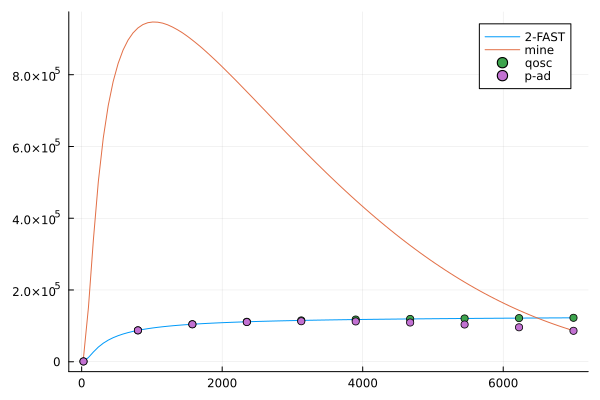

In [87]:
plot(LinRange(26, 7000, 100) ,w00_LL_interp, label="2-FAST")
plot!(LinRange(26, 7000, 100), diag(w_LL[1,:,:]), label="mine")
#scatter!(LinRange(26, 7000, 10), qosc_test_ll_a, label="qosc_a")
scatter!(LinRange(26, 7000, 10), qosc_test_ll_a .- qosc_test_ll_b, label="qosc")
scatter!(LinRange(26, 7000, 10), ll_padapt, label="p-ad")

In [88]:
diag(w_LL[1,:,:])[100]

86198.11392758145

In [90]:
ll_padapt[10]

86198.29687604985

In [91]:
qosc_test_ll_a[10] .- qosc_test_ll_b[10]

122458.00759625844

In [92]:
w00_LL_interp[100]

122438.16635025715

### CL

In [98]:
N = 4096
chi0 = 0.001
kmax = 1e4 #200/13 
kmin = 4e-5 #2.5/7000
q = 0.5
ell = [2] 
RR = [1.0]

# calculate M_ll at high ell, result gets saved to a file:
f21cache = F21EllCache(maximum(ell), RR, N; q=q, kmin=kmin, kmax=kmax, χ0=chi0)
write("out/F21EllCache", f21cache)

# calculate all M_ll, result gets saved to a file:
mlcache = MlCache(ell, "out/F21EllCache", "out/MlCache")
write("out/MlCache", mlcache)

# calculate wljj:
w00_CL = Array{Float64}(undef, N, length(RR))
function outfunc(wjj, ell, rr, RR)
    w00_CL[:,:] = wjj[1]
    #w02[:,:] = wjj[2]
    #w22[:,:] = wjj[3]
end
rr = calcwljj(x->power_spectrum(log10(x), 7000, 7000)/x^2, RR; ell=ell, kmin=kmin, kmax=kmax, N=N, r0=chi0, q=q, outfunc=outfunc, cachefile="out/MlCache/MlCache.bin");

  q=0.5, R=1.0:	  0.003546 seconds (8.20 k allocations: 576.281 KiB)

ℓ = 2
Δℓ = 4
ΔℓRg1 = -4
N = 4096
q = 0.5
kmin = 4.0e-5
kmax = 10000.0
χ0 = 0.001
RR = RR.tsv
ℓmax = ℓmax.bin
f21 = f21.bin
kmin = 4.0e-5
kmax = 10000.0
dlrec    = 4
dlrecRg1 = -4
Output size: 131136 bytes = 0.0001221299171447754 GiB
Output size: 131136 bytes = 0.0001221299171447754 GiB
Reading 'out/F21EllCache'...   0.012516 seconds (180 allocations: 132.078 KiB)
ellmax: 4
lmaxcache: 2
fell[:,1,1] = ComplexF64[-20.999681077030456 + 2.571719221410059e-15im, 0.0 + 0.0im]
ell 4, elapsed: 0.0001938343048095703
ell 3, elapsed: 0.0009691715240478516
ell 2, elapsed: 0.0005481243133544922
ell 1, elapsed: 0.002315998077392578
ell 0, elapsed: 0.004716157913208008
  0.011780 seconds (339 allocations: 18.094 KiB)
elapsed: 0.002476930618286133
step:          0.000173 sec (0 allocations: 0 byte, 0.0% gc time)
swapping:      6.0e-6 sec (0 allocations: 0 byte, 0.0% gc time)
calc_Mellell!: 0.000127 sec (0 allocations: 0 byte, 0.0% gc

In [99]:
interp= Spline1D(rr, w00_CL[:,1])
w00_CL_interp = interp.(LinRange(26, 7000, 100) )*π/2;

In [100]:
function load_T_CL(nχ, n_cheb, ell_list="ell_vector.npy")
    ell_vector = npzread(ell_list) 
    full_T = zeros(21, nχ, nχ, n_cheb+1)
    for i in 1:21
        l_string = string(round(ell_vector[i]; digits=1))
        filename = "T_tilde_CL/T_tilde_l_$l_string.npy"
        full_T[i,:,:,:] = npzread(filename)
    end
    return full_T
end

T_CL = load_T_CL(nχ, n_cheb)
w_CL = Will.w_ell_tullio(coeff, T_CL);

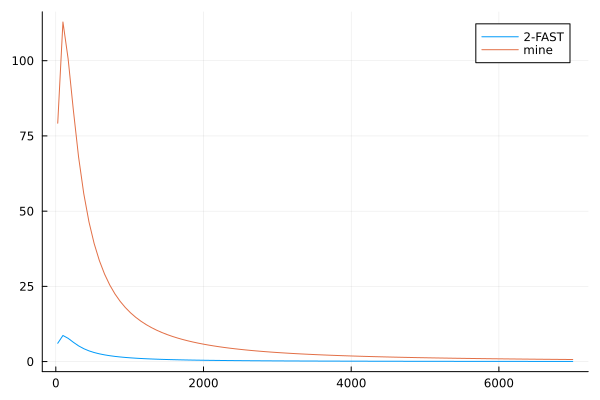

In [101]:
plot(LinRange(26, 7000, 100) ,w00_CL_interp, label="2-FAST")
#plot(rr ,w00, label="2-FAST", xscale=:log10, yscale=:log10)
plot!(LinRange(26, 7000, 100), diag(w_CL[1,:,:]), label="mine")

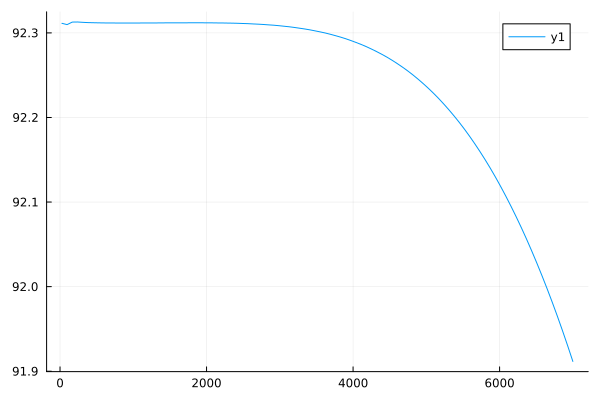

In [103]:
plot(LinRange(26, 7000, 100), 100*(1 .- w00_CL_interp ./ diag(w_CL[1,:,:])))

In [28]:
function quadosc_cl_valid(ℓ, χ)
    a, E = quadosc(x->pk(log10(x))*Bessels.sphericalbesselj(ℓ, χ*x)^2, kmin, Inf, n->besselj_zero(ℓ+0.5, n)/χ)
    b, Eb = quadosc(x->pk(log10(x))*Bessels.sphericalbesselj(ℓ, χ*x)^2, kmax, Inf, n->besselj_zero(ℓ+0.5, n)/χ)
    return a,b
end;

In [29]:
χ = LinRange(26, 7000, 10)
qosc_test_cl_a = zeros(10)
qosc_test_cl_b = zeros(10)
for (cidx, c) in enumerate(χ)
    println("Processing χ = $c");flush(stdout)
    qosc_test_cl_a[cidx], qosc_test_cl_b[cidx]  = quadosc_cl_valid(2, c)
end

Processing χ = 26.0
Processing χ = 800.8888888888888
Processing χ = 1575.7777777777776
Processing χ = 2350.6666666666665
Processing χ = 3125.555555555555
Processing χ = 3900.444444444445
Processing χ = 4675.333333333333
Processing χ = 5450.222222222222
Processing χ = 6225.11111111111
Processing χ = 7000.0


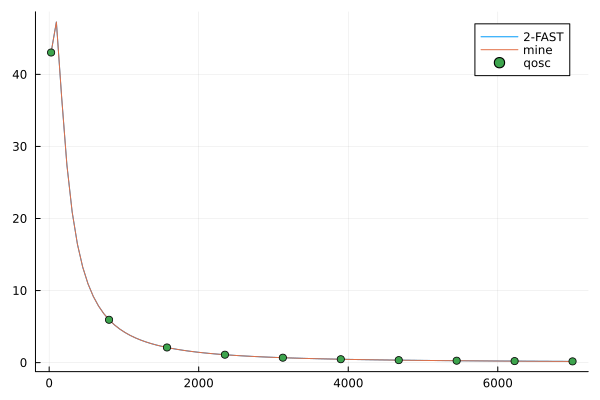

In [30]:
plot(LinRange(26, 7000, 100) ,w00_CL_interp, label="2-FAST")
plot!(LinRange(26, 7000, 100), diag(w_CL[1,:,:]), label="mine")
scatter!(LinRange(26, 7000, 10), qosc_test_cl_a .- qosc_test_cl_b, label="qosc")

In [31]:
function cl_p_ad(f, kmin, kmax, ℓ, χ)
    benchmark_f(x) = Bessels.sphericalbesselj.(ℓ, χ * x) * Bessels.sphericalbesselj.(ℓ, χ * x)*f(log10(x))
    int, err = Cubature.pquadrature(x->benchmark_f(x), kmin*(1+1e-8), kmax; reltol=sqrt(1e-14), abstol=0, maxevals=Int(1e6))
   return int
end

cl_p_ad (generic function with 1 method)

In [32]:
cl_padapt = zeros(10)
χ = LinRange(26, 7000, 10)

kmax = 200/13
kmin = 2.5/7000

@time for (cidx,c) in enumerate(χ)
    println("Processing χ = $c")
    cl_padapt[cidx] = cl_p_ad(pk, kmin, kmax, 2, c)
end

Processing χ = 26.0
Processing χ = 800.8888888888888
Processing χ = 1575.7777777777776
Processing χ = 2350.6666666666665
Processing χ = 3125.555555555555
Processing χ = 3900.444444444445
Processing χ = 4675.333333333333
Processing χ = 5450.222222222222
Processing χ = 6225.11111111111
Processing χ = 7000.0
  0.254316 seconds (101.67 k allocations: 6.801 MiB, 39.94% compilation time)


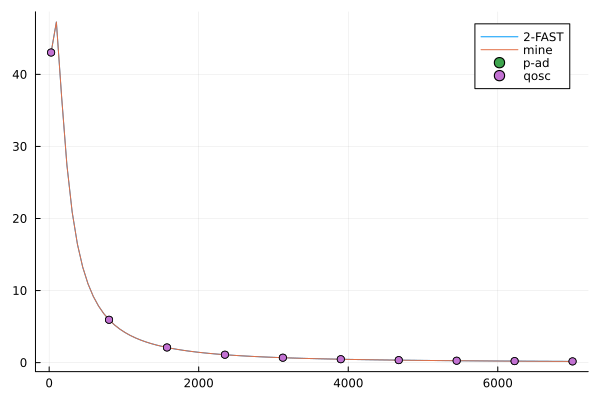

In [33]:
plot(LinRange(26, 7000, 100) ,w00_CL_interp, label="2-FAST")
plot!(LinRange(26, 7000, 100), diag(w_CL[1,:,:]), label="mine")
scatter!(LinRange(26, 7000, 10), cl_padapt, label="p-ad")
scatter!(LinRange(26, 7000, 10), qosc_test_cl_a .- qosc_test_cl_b, label="qosc")